Import libraries

In [54]:
import pandas as pd
import numpy as np
import torch as T
import torchvision as tv

Define device

In [55]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print(device)

cuda


Define Class Net

In [56]:
class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = T.nn.Conv2d(3, 6, 5).cuda()  # in, out, kernel
    self.conv2 = T.nn.Conv2d(6, 16, 5).cuda()
    self.pool = T.nn.MaxPool2d(2, 2).cuda()   # kernel, stride
    self.fc1 = T.nn.Linear(16 * 5 * 5, 120).cuda()
    self.fc2 = T.nn.Linear(120, 84).cuda()
    self.fc3 = T.nn.Linear(84, 10).cuda()  

  def forward(self, x):
    z = T.nn.functional.relu(self.conv1(x)).cuda()
    z = self.pool(z).cuda()
    z = T.nn.functional.relu(self.conv2(z)).cuda()
    z = self.pool(z).cuda()

    z = z.view(-1, 16 * 5 * 5).cuda()
    z = T.nn.functional.relu(self.fc1(z)).cuda()
    z = T.nn.functional.relu(self.fc2(z)).cuda()
    z = self.fc3(z).cuda()
    return z


Define accuracy model

In [57]:
def accuracy(model, ds):
  ldr = T.utils.data.DataLoader(ds,
    batch_size=len(ds), shuffle=False)
  n_correct = 0
  for data in ldr:
    (pixels, labels) = data
    pixels, labels = pixels.to(device), labels.to(device)
    with T.no_grad():
      oupts = model(pixels)
    (_, predicteds) = T.max(oupts, 1)
    n_correct += (predicteds == labels).sum().item()

  acc = (n_correct * 1.0) / len(ds)
  return acc


Begin program

In [58]:
print("\nBegin CIFAR-10 program")
np.random.seed(1)
T.manual_seed(1)


Begin CIFAR-10 program


Load and read dataset

In [59]:
print("\nCreating Dataset ")
trfm = tv.transforms.Compose([ tv.transforms.ToTensor() ])
train_ds = tv.datasets.CIFAR10(root=".\\Data", train=True, download=True, transform=trfm)
test_ds = tv.datasets.CIFAR10(root=".\\Data", train=False, download=True, transform=trfm)
bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)
test_ldr = T.utils.data.DataLoader(test_ds, batch_size=bat_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Creating Dataset 
Files already downloaded and verified
Files already downloaded and verified


Create CNN

In [60]:
print("\nCreating CNN with 2 conv and 400-120-84-10 ")
net = Net().to(device).cuda()


Creating CNN with 2 conv and 400-120-84-10 


Train CNN

In [61]:
max_epochs = 25
ep_log_interval = 5
lrn_rate = 0.005

loss_func = T.nn.CrossEntropyLoss()  # does log-softmax()
optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = SGD")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.to(device).train()
for epoch in range(0, max_epochs):
  epoch_loss = 0  # for one full epoch
  num_lines_read = 0
  
  for (batch_idx, batch) in enumerate(train_ldr):
    X, Y = batch  # X = pixels, Y = target labels
    X, Y = X.to(device), Y.to(device)
    num_lines_read += bat_size  # not exactly

    optimizer.zero_grad()
    oupt = net(X)  # X is Size([bat_size, 3, 32, 32])
    loss_obj = loss_func(oupt, Y)  # a tensor
    epoch_loss += loss_obj.item()  # accumulate
    loss_obj.backward()
    optimizer.step()
  if epoch % ep_log_interval == 0:
    print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
print("Training complete ") 


bat_size =  10 
loss = CrossEntropyLoss()
optimizer = SGD
max_epochs =  25 
lrn_rate = 0.005 

Starting training
epoch =    0   loss = 11077.7373
epoch =    5   loss = 6731.0079
epoch =   10   loss = 5657.0020
epoch =   15   loss = 4914.6783
epoch =   20   loss = 4298.0348
Training complete 


Evaluate CNN accuracy

In [62]:
print("\nComputing model accuracy")
net = net.eval()
acc_train = accuracy(net, train_ds)  # item-by-item
print("Accuracy on training data = %0.4f" % acc_train)


Computing model accuracy
Accuracy on training data = 0.7396


Make a prediction

In [63]:
print("\nPredicting image for random 32x32 pixels ")
cifar = ['plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
inpt = np.random.random((1, 3, 32, 32))
inpt = T.tensor(inpt, dtype=T.float32).to(device)
with T.no_grad():
  oupt = net(inpt).cuda()  # like [[-0.12, 1.03, 0.55, . . ]]
  am = T.argmax(oupt).cuda() # 0 to 9
print("\nPredicted class is " + cifar[am] )


Predicting image for random 32x32 pixels 

Predicted class is frog


Predict on test set

In [64]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with T.no_grad():
    for data in test_ldr:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = T.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 60.82%


Confusion matrix

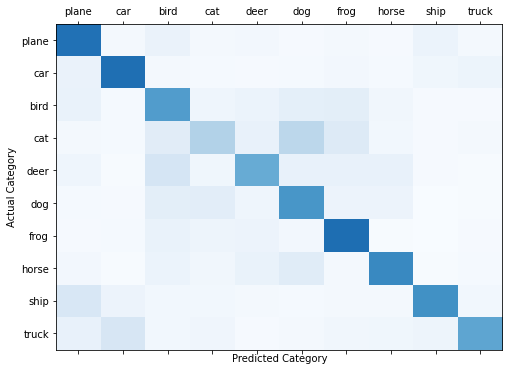

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [66]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     plane     car       bird      cat       deer      dog       frog      horse     ship      truck     
plane           747       22        66        17        27        8         22        10        60        21        
                0.747     0.022     0.066     0.017     0.027     0.008     0.022     0.01      0.06      0.021     
car             63        757       18        12        9         13        25        12        39        52        
                0.063     0.757     0.018     0.012     0.009     0.013     0.025     0.012     0.039     0.052     
bird            67        12        575       44        61        90        101       32        10        8         
                0.067     0.012     0.575     0.044     0.061     0.09      0.101     0.032     0.01      0.008     
cat             21        12        110       309       78        281       129       31        9         20        
                0.021     0.012     0.11      0.309     0.078   

Save CNN

In [67]:
print("\nSaving trained model state")
fn = ".\\Models\\cifar_model.pth"
T.save(net.state_dict(), fn)  


Saving trained model state


In [69]:
print("\nEnd CIFAR-10 program")


End CIFAR-10 program
